# Enumeration speed analysis

Compares the enumeration speed of ocaml enumeration and python enumeration to find rough equivalence in compute needed

In [16]:
ts = (10, 60, 300)
domains = ("re2", "clevr")
solvers = ("python", "ocaml", "pypy")

base_path = "../experiments_iterative/outputs/"

In [17]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

In [18]:
def get_n_progs(run_log: str):
    try:
        prefix_i = run_log.index("We enumerated this many programs, for each task:")
    except ValueError:
        return None
    start_i = run_log[prefix_i:].find("[")
    end_i = run_log[prefix_i:].find("]")
    n_progs = run_log[prefix_i + start_i:prefix_i + end_i + 1]
    n_progs = json.loads(n_progs)
    return n_progs

In [19]:
n_solved = {}
for domain in domains:
    n_solved[domain] = {}
    for solver in solvers:
        n_solved[domain][solver] = {}
        for t in ts:
            dir_name = os.path.join(base_path, f"{solver}_enum{t}", "domains", domain, "enumeration")
            if not os.path.exists(dir_name):
                continue
            for seed_dir in os.listdir(dir_name):
                fpath = os.path.join(dir_name, seed_dir, "enumeration_all", "run.log")
                if not os.path.exists(fpath):
                    continue
                with open(fpath, "r") as f:
                    progs_searched = get_n_progs(f.read().strip())
                    if progs_searched is None:
                        continue
                    n_solved[domain][solver].setdefault(t, []).append(np.mean(progs_searched))

n_solved


{'re2': {'python': {10: [113.0, 113.0, 113.0],
   60: [1010.0, 1010.0, 1010.0],
   300: [3891.45]},
  'ocaml': {10: [7349.66, 11856.28, 4951.82],
   60: [53760.76, 42197.36, 42201.16],
   300: [264313.06]},
  'pypy': {10: [1.0], 60: [3726.0]}},
 'clevr': {'python': {10: [256.29, 300.48, 297.67],
   60: [2320.25, 3754.16, 4023.9],
   300: [16287.72]},
  'ocaml': {10: [12926.08, 14718.46, 14131.65],
   60: [52474.59, 49913.63, 50593.94],
   300: [229268.67]},
  'pypy': {10: [5.68], 60: [1431.61]}}}

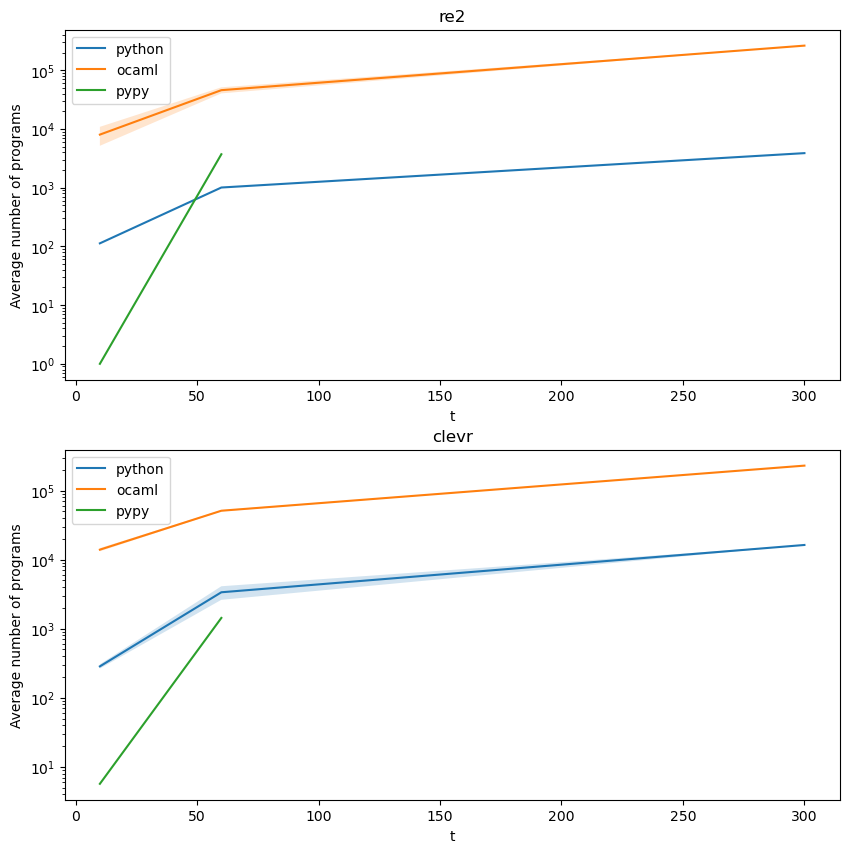

In [20]:
fig, axes = plt.subplots(len(domains), 1, figsize=(10, 5 * len(domains)))
axes = [axes] if len(domains) == 1 else axes.flatten()
for i, domain in enumerate(domains):
    ax = axes[i]
    ax.set_title(domain)
    for solver in solvers:
        solver_res = n_solved[domain][solver]
        if not solver_res:
            continue
        solver_ts = [t for t in ts if t in solver_res]
        solve_mean = np.array([np.mean(solver_res[t]) for t in solver_ts])
        solve_std = np.array([np.std(solver_res[t]) for t in solver_ts])
        ax.plot(solver_ts, solve_mean, label=solver)
        ax.fill_between(solver_ts, solve_mean - solve_std, solve_mean + solve_std, alpha=0.2)
    ax.set_xlabel("t")
    ax.set_ylabel("Average number of programs")
    ax.set_yscale("log")
    ax.legend()

In [15]:
# Print how much faster the fastest is than the other methods.
for domain in domains:
    print(domain)
    for t in ts:
        fastest = max(solvers, key=lambda s: np.mean(n_solved[domain][s].get(t, 0)))
        for solver in solvers:
            if solver == fastest or t not in n_solved[domain][solver]:
                continue
            ratio = np.mean(n_solved[domain][fastest][t]) / np.mean(n_solved[domain][solver][t])
            print(f"\tt={t} {fastest} is {ratio:.2f} times faster than {solver}")
        

re2
	t=10 ocaml is 71.26 times faster than python
	t=10 ocaml is 8052.59 times faster than pypy
	t=60 ocaml is 45.60 times faster than python
	t=60 ocaml is 12.36 times faster than pypy
	t=300 ocaml is 67.92 times faster than python
clevr
	t=10 ocaml is 48.89 times faster than python
	t=60 ocaml is 15.15 times faster than python
	t=300 ocaml is 14.08 times faster than python
